In [16]:
import numpy as np

import pandas as pd
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas.plotting import autocorrelation_plot

import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.tsa.stattools as st


import seaborn as sns

from sklearn.metrics import mean_squared_error

C:\Users\vitor\AppData\Local\Temp\ipykernel_2232\779787555.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [17]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

In [18]:
def ARIMA_plot_ki(series, 
               order,
               train_size_percent,
               scale=1):
    
    # Credit to Fong King Ian for providing this code

    # convert Series to DataFrame
    # remove duplicated rows except for most recent, convert to daily freq, fil blanks with prev observation
    X = series.rename("actual").to_frame() 
    X = X.loc[~X.index.duplicated(keep='last')].asfreq('d', 'ffill')
    
    # determine where the training set ends and the test set starts
    size = int(len(X) * train_size_percent)
    first_test_index = X.index[size]
        
    # forecast out-of-sample value using ARIMA
    for t in X[X.index >= first_test_index].index.tolist():
        # fit model with 'actual' values up to and excluding time t
        model = ARIMA(X[X.index < t]['actual'].values, order)
        model_fit = model.fit(disp=0)
        
        # forecast returns 3 arrays: 
        # out-of-sample forecast value, std error of the forecast and 
        # 2d array of the confidence interval for the forecast 
        
        output = model_fit.forecast()
        X.loc[t, 'predictions'] = output[0]  # output[0] contains forecast value
#        print('predicted = %f, expected = %f' % (output[0], X.at[t, 'actual']))
    
    # aligning predictions with correct time periods, removing rows without predictions
    X['predictions'] = X['predictions'].shift(-1)
    X.dropna(inplace = True)
    
    # MSE
    error = mean_squared_error(X['actual'].values, X['predictions'].values)
    print('Test MSE: %.3f' % error)
    
    # Scale to avoid exceeding maximum margin of plots
    test_scaled = X['actual'].values / scale
    predictions_scaled = X['predictions'].values / scale

    # plot
    plt.plot(test_scaled, color='blue', label='true values')
    plt.plot(predictions_scaled, color='red', label=f'estimated ARIMA{order}')
    plt.legend(loc='upper left')
    plt.show()

In [19]:
def ARIMA_plot(series, 
               order,
               train_size_percent,
               scale = 1):
    
    # Split data points into train and test sets
    X = series
    size = int(len(X) * train_size_percent)
    train, test = X[0:size], X[size:len(X)]
    history = list(train)
    predictions = []
    
    # Forecast out-of-sample value using ARIMA
    for t in range(len(test)):
        model = ARIMA(history, order)     
        model_fit = model.fit(disp=0)
        # forecast returns 3 arrays: 
        # out-of-sample forecast value, std error of the forecast and 
        # 2d array of the confidence interval for the forecast 
        output = model_fit.forecast()
        # yhat contains forecast value
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
    
    # MSE
    error = mean_squared_error(test, predictions)
    print('Test MSE: %.3f' % error)
    
    # Scale to avoid exceeding maximum margin of plots
    test_scaled = [x/scale for x in test]
    predictions_scaled = [x/scale for x in predictions]

    # plot
    plt.plot(test_scaled, color = 'blue', label = 'true values')
    plt.plot(predictions_scaled, color='red', label = 'estimated ARIMA{}'.format(order))
    plt.legend(loc='upper left')
    plt.show()

In [20]:
def parser(x):
    return datetime.strptime(x, '%Y-%m-%d')

In [21]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [22]:
def fit_ARIMA(series, order):
    model = ARIMA(series, order)
    model_fit = model.fit(disp=0)
    return model_fit.summary()

In [23]:
def AIC_BIC_HIQC(series, max_ar = 4, max_ma= 4):
    train_results = sm.tsa.arma_order_select_ic(series, ic=['aic', 'bic', 'hqic'], trend='nc', max_ar=max_ar, max_ma=max_ma)

    print('AIC', train_results.aic_min_order)
    print('BIC', train_results.bic_min_order)
    print('HQIC', train_results.hqic_min_order)

In [24]:
def adf(series):
    adf_result = st.adfuller(series, store = True)
    print("ADF Test Results: ")
    print("Test Statistic: %.4f" % adf_result[0])
    print("p-value: %.10f" % adf_result[1])
    print("Critical Values: ")
    for key, value in adf_result[2].items():
        print('\t%s: %0.3f' % (key, value))

In [25]:
def kpss(series):
    kpss_result = st.kpss(series, store=True)
    print("KPSS Test Results: ")
    print("Test Statistic: %.4f" % kpss_result[0])
    print("p-value: %.10f" % kpss_result[1])
    print("Critical Values: ")
    for key, value in kpss_result[2].items():
        print('\t%s: %0.3f' % (key, value))

======================================================================================================================

## Load Data Sets and Differencing Technique

In [26]:
# Download Bitcoin's and Amazon's historical price in yahoo Finance as csv file
BitCoin = read_csv('BTC-USD.csv', 
                               header = 0, 
                               parse_dates = [0],  
                               index_col = 0, 
                               squeeze = True, 
                               date_parser = parser)

Amazon = read_csv('amzn.csv',  
                  header = 0, 
                  parse_dates = [0],
                  index_col = 0,
                  squeeze = True,
                 date_parser = parser)

AAPL_df = read_csv('AAPL.csv',
                  header = 0, 
                  parse_dates = [0],  
                  index_col = 0, 
                  squeeze = True, 
                  date_parser = parser)

temp_df = read_csv('daily-minimum-temperatures.csv', header=0)

C:\Users\vitor\AppData\Local\Temp\ipykernel_2232\3295134375.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  BitCoin = read_csv('BTC-USD.csv',
C:\Users\vitor\AppData\Local\Temp\ipykernel_2232\3295134375.py:9: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  Amazon = read_csv('amzn.csv',
C:\Users\vitor\AppData\Local\Temp\ipykernel_2232\3295134375.py:16: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  AAPL_df = read_csv('AAPL.csv',


In [27]:
BitCoin.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-07-18,7383.390137,7563.700195,7289.899902,7477.500000,7477.500000,522544440
2018-07-19,7477.100098,7676.549805,7279.339844,7333.930176,7333.930176,603034414
2018-07-20,7333.930176,7453.069824,7220.370117,7405.399902,7405.399902,297440355
2018-07-21,7405.399902,7569.279785,7345.250000,7398.640137,7398.640137,355565264
2018-07-22,7398.640137,7798.589844,7376.660156,7718.000000,7718.000000,745533303


In [28]:
BitCoin.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2018-07-18 to 2019-07-19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       366 non-null    float64
 1   High       366 non-null    float64
 2   Low        366 non-null    float64
 3   Close      366 non-null    float64
 4   Adj Close  366 non-null    float64
 5   Volume     366 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 20.0 KB


In [29]:
BitCoin.describe()

,Open,High,Low,Close,Adj Close,Volume
count,366.000000,366.000000,366.000000,366.000000,366.000000,3.660000e+02
mean,6004.344969,6165.423819,5845.735810,6012.809532,6012.809532,3.885772e+08
std,2197.605684,2309.237345,2082.604271,2208.962864,2208.962864,3.224718e+08
min,3232.510010,3271.760010,3169.530029,3232.510010,3232.510010,5.672742e+07
25%,3938.335022,4018.497498,3849.284973,3938.335022,3938.335022,1.744939e+08
50%,6250.584961,6373.560059,6133.984863,6249.959961,6249.959961,2.941960e+08
75%,7038.667358,7262.729858,6868.762451,7038.532593,7038.532593,4.789539e+08
max,12913.280273,13826.759766,12117.309570,12913.280273,12913.280273,2.685872e+09


c:\Users\vitor\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


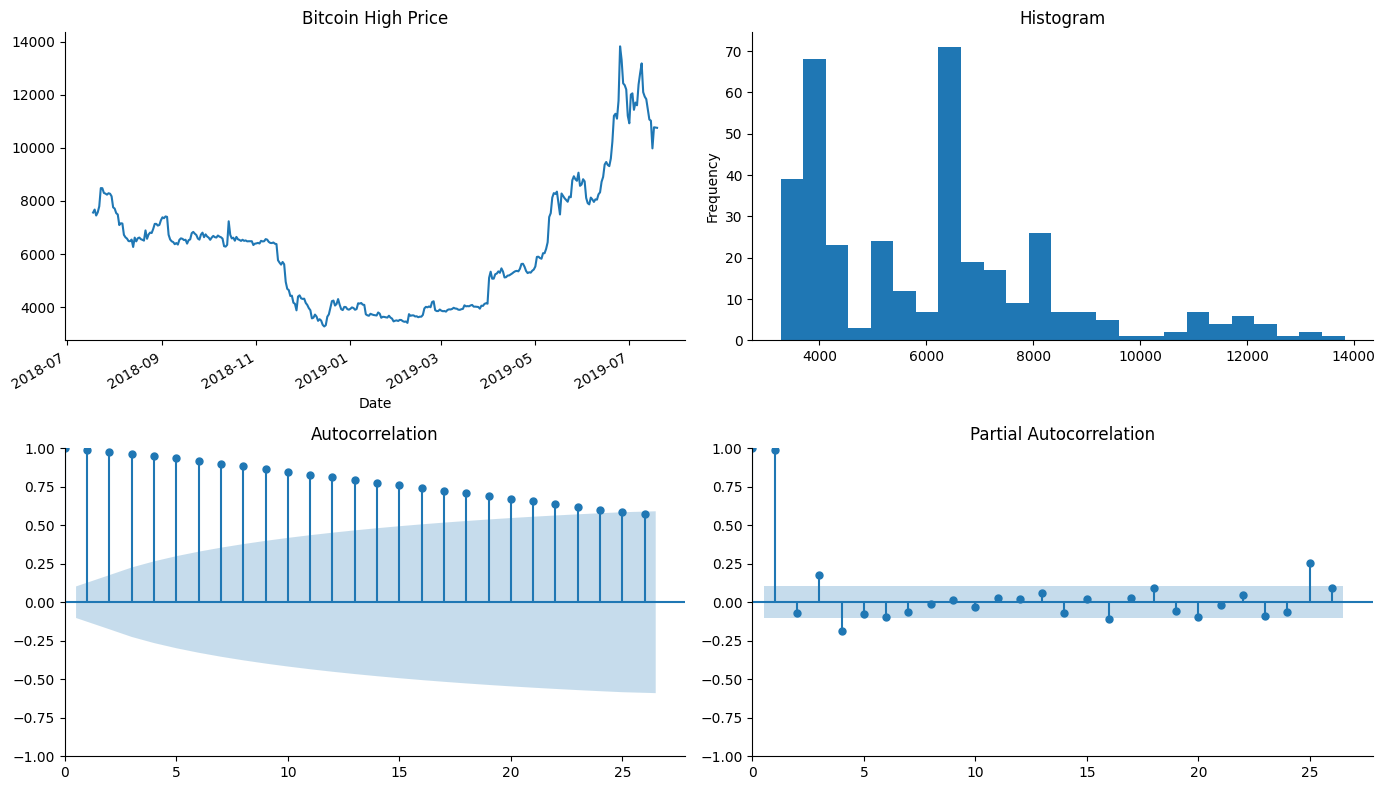

In [30]:
tsplot(BitCoin['High'], title = 'Bitcoin High Price');

* Not all time series are stationary. In fact, most financial time series lack of stationarity.

* One method to 'stationarize' non-stationary time series is through differencing

* Notation: $\nabla = 1 - L$ where $L$ is the lag operator

* Advantage of differencing: 

    (1) No parameter estimation is required  

    (2) Can be repeated such that first difference $\nabla$ eliminates a linear trend whereas second difference $\nabla^2$ eliminates a quadratic trend

* Order of differencing $d$: $\nabla^d = (1-L)^d$

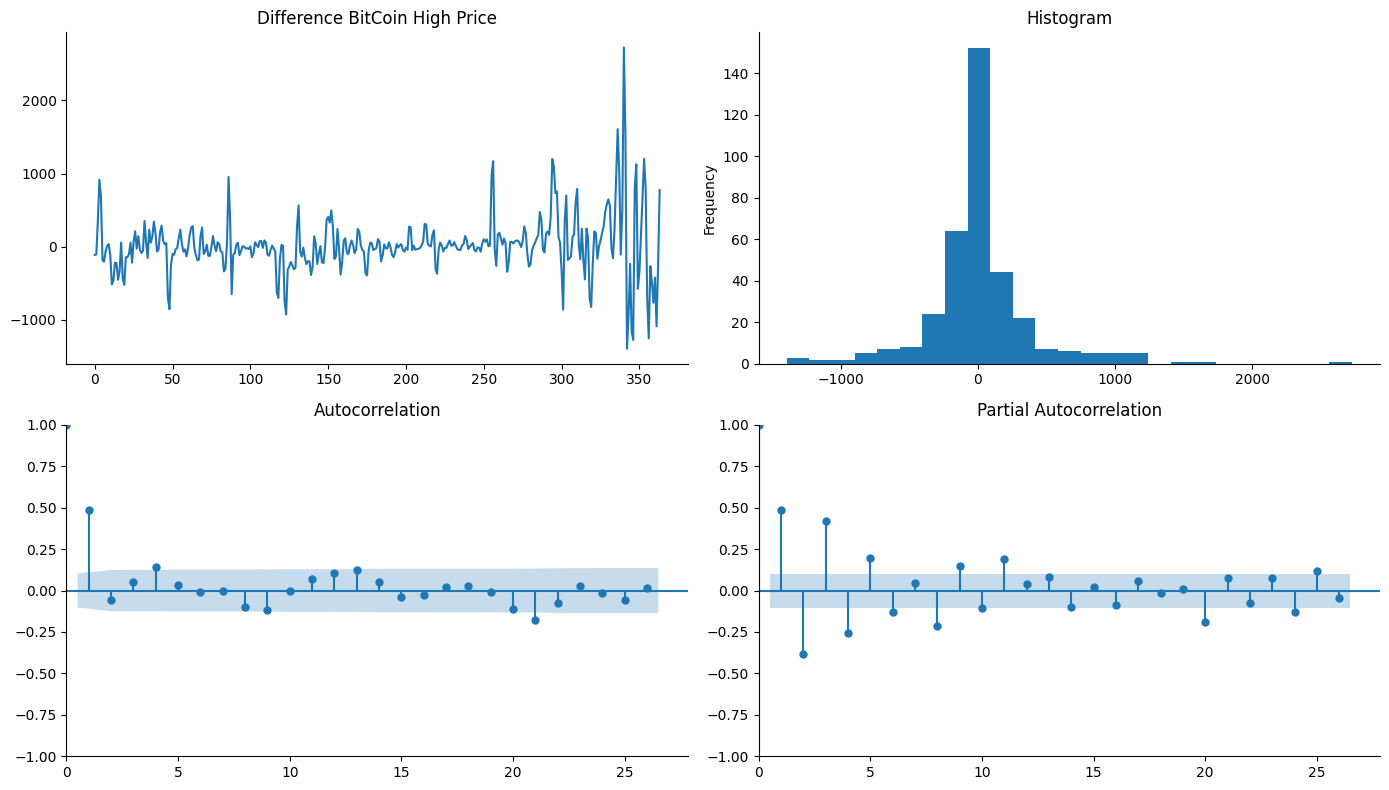

In [31]:
# Difference Bitcoin high price by one interval
Bitcoin_high_diff = difference(BitCoin['High'], 2)
tsplot(Bitcoin_high_diff, title = 'Difference BitCoin High Price');

* Is the differenced Bitcoin High price series stationary?

In [19]:
adf(Bitcoin_high_diff)

ADF Test Results: 
Test Statistic: -4.7748
p-value: 0.0000607427
Critical Values: 
	1%: -3.449
	5%: -2.870
	10%: -2.571


* Test statistics is less than all critical values. So according to ADF test, we can reject null hypothesis and conclude that the difference series is indeed stationary.

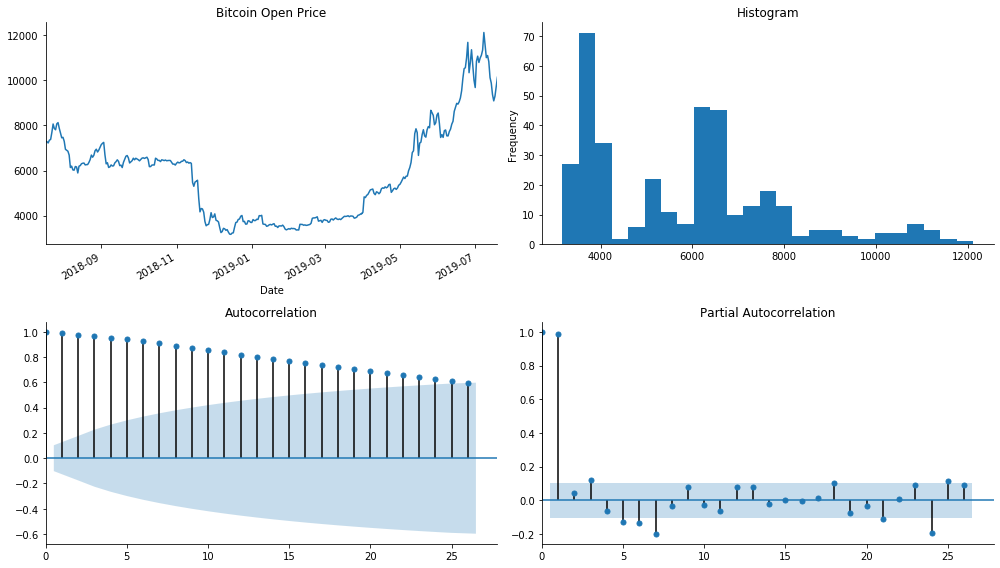

In [21]:
tsplot(BitCoin['Low'], title = 'Bitcoin Open Price');

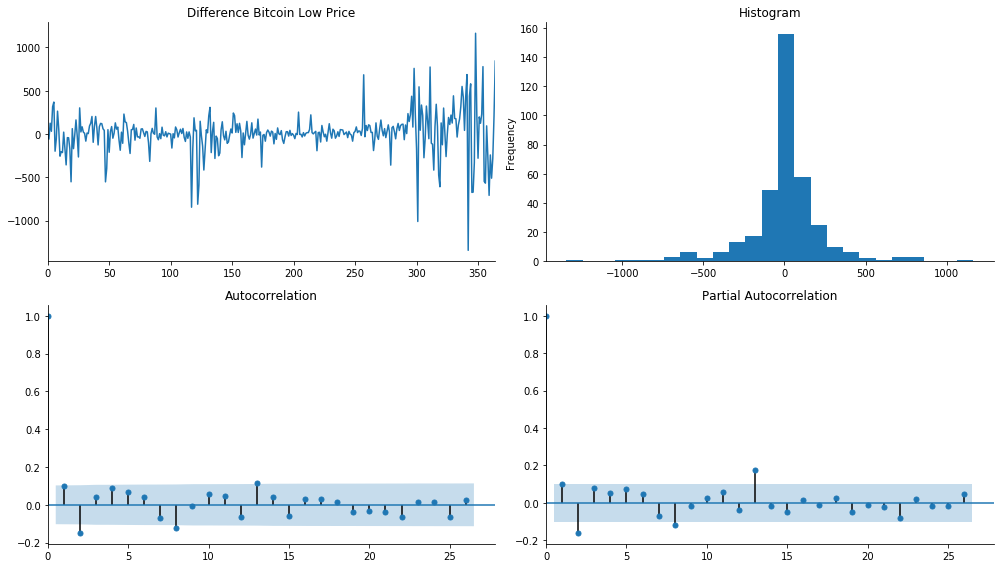

In [22]:
# Difference Bitcoin low price by one interval
Bitcoin_low_diff = difference(BitCoin['Low'], 1)
tsplot(Bitcoin_low_diff, title = 'Difference Bitcoin Low Price');

In [23]:
adf(Bitcoin_low_diff)

ADF Test Results: 
Test Statistic: -4.2231
p-value: 0.0006019658
Critical Values: 
	1%: -3.449
	5%: -2.870
	10%: -2.571


* Again, the test statistics is less than all critical values. So we reject null hypothesis and conclude that the difference series is stationary.

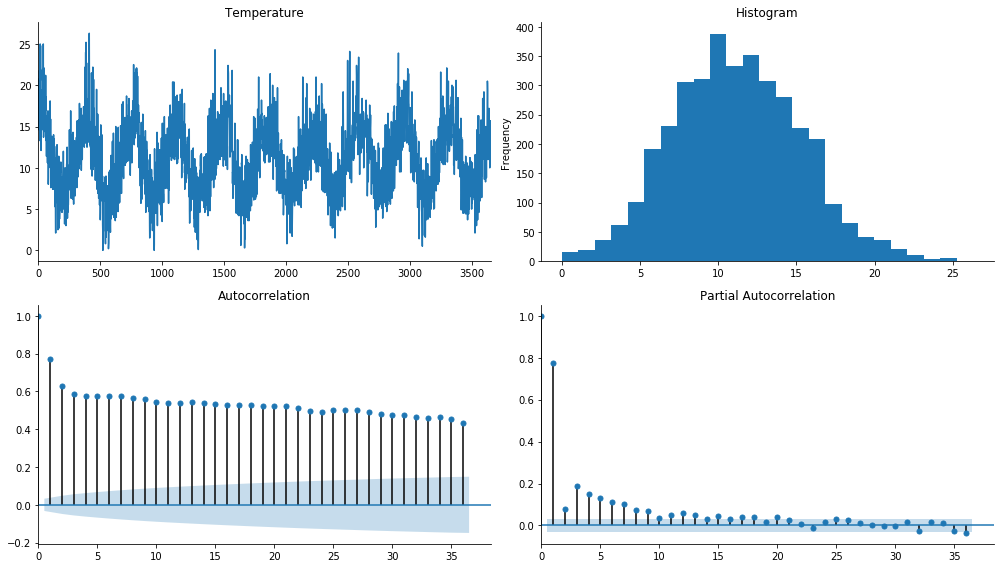

In [24]:
tsplot(temp_df['Temp'], title = 'Temperature');

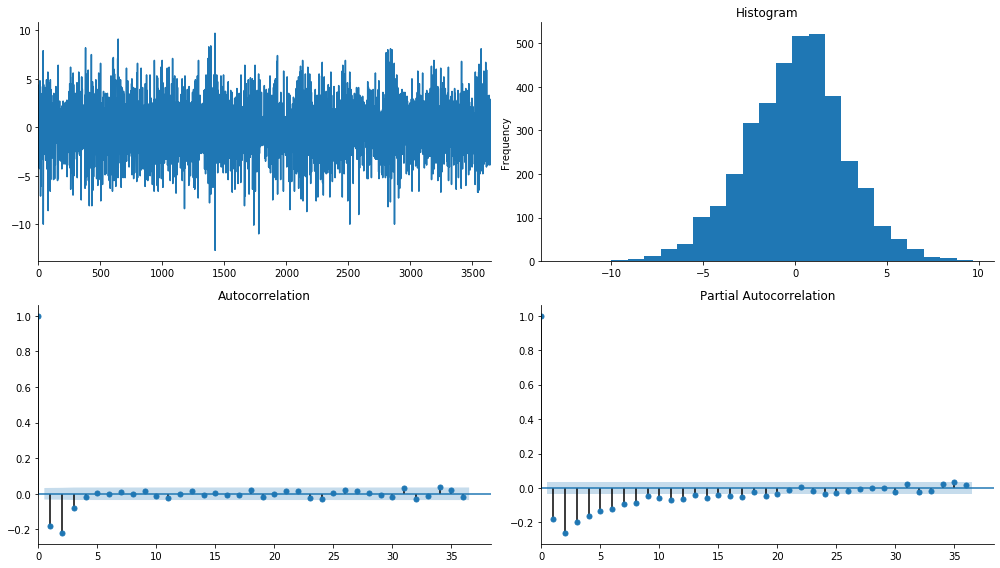

In [25]:
# difference temperature by one interval
temp_df_diff = difference(temp_df['Temp'])
tsplot(temp_df_diff);

In [26]:
adf(temp_df_diff)

ADF Test Results: 
Test Statistic: -18.0282
p-value: 0.0000000000
Critical Values: 
	1%: -3.432
	5%: -2.862
	10%: -2.567


* Test statistics is less than all critical values. So the difference series is stationary.

======================================================================================================================

## ARIMA$(p,d,q)$ Model

* A time series $\{X_t\}$ follows an ARIMA$(p,d,q)$ process if the $d^{th}$ differences $(1-L)^d X_t$ series is an ARMA($p,q$) process. Using lag operator $L$, it can expressed as 

$$\begin{equation}
  \phi(L)(1-L)^d X_t = c + \theta(L) \epsilon_t
\end{equation}$$

where $\phi(L) = 1 - \phi_1 L - \phi_2 L^2 - ... - \phi_p L^p$ and $\theta_q = 1 + \theta_1 L + \theta_2 L^2 - ... + \theta_q L^q.$

* In Python, $d=0,1,2.$ Higher value of $d$ is not accepted.

### Box Jenkins Method (ARIMA Model Identification)

* To estimate the parameters of a specific ARIMA$(p, d, q)$ model:

* To check on the appropriateness of the fitted model and improve it if needed.
 



1. **Model identification and model selection:** Determine the *order of differencing*, $d$

2. **Parameter estimation:** Study the ACF and PACF of the appropriately differenced series: $(1-L)^d X_t$, as these autocorrelation functions will provide indication for the choice of the order of autoregressive and the moving average components.  It is very beneficial to study the *theoretical* ACF and PACF of the autoregressive, moving average, and the mixed autoregressive and moving average processes.

3. **Model checking**: Test whether the estimated model conforms to the specifications of a stationary univariate process. In particular, the residuals should be independent of each other and constant in mean and variance over time. If the estimation is inadequate, we have to return to step one and attempt to build a better model.


* Let us recall the following table.

|  Process      |          ACF         |          PACF        |
|---------------|:--------------------:|:--------------------:|
| **AR(p)**     |    tails off         | cutoff after lag $p$ |
| **MA(q)**     | cutoff after lag $q$ |    tails off         |
| **ARMA(p,q)** |    tails off         |    tails off         |


* In general, the ACF of an autoregressive process is similar to the PACF of a moving average process, and vice versa.

* Keep in mind that these are theoretical properties. In practice, the estimated sample ACF and PACF can come with large variances, deviating from the underlying theoretical behavior. As such, it is prudent to recognize that these are  but broad characteristics, and it is quite possible that several candidate models are narrowed down and will need to be investigaged further in the later stage of the modeling process.

|  Process      |          ACF         |          PACF        |
|---------------|:--------------------:|:--------------------:|
| **ARIMA(p,d,0)**     |    tails off         | cutoff after lag $p$ |
| **ARIMA(0,d,q)**     | cutoff after lag $q$ |   tails off         |
| **ARIMA(p,d,q)** |   tails off         |   tails off         |


In [ ]:
# from IPython.display import Image
# Image(filename = 'ARIMA FLOW CHART.jpg', width = 200, height = 200 )

==================================================================================================================

## ARIMA Fitting

* In this section, we will fit ARIMA to BitCoin, Amazon and Apple high prices.

### Bitcoin High Price

In [27]:
print(fit_ARIMA(BitCoin['High'], order=(4,2,3)))

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                             ARIMA Model Results                              
Dep. Variable:                D2.High   No. Observations:                  364
Model:                 ARIMA(4, 2, 3)   Log Likelihood               -2538.925
Method:                       css-mle   S.D. of innovations            254.485
Date:                Mon, 11 May 2020   AIC                           5095.851
Time:                        16:35:58   BIC                           5130.925
Sample:                             2   HQIC                          5109.791
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2643      0.131      2.013      0.045       0.007       0.522
ar.L1.D2.High    -0.7583      0.054    -14.076      0.000      -0.864      -0.653
ar.L2.D2.High    -0.9823      0.067    -

C:\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Test MSE: 52926.052


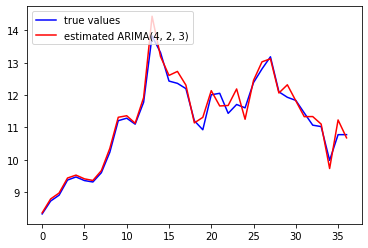

In [28]:
ARIMA_plot_ki(series = BitCoin['High'], order = (4,2,3), train_size_percent = 0.9, scale = 1000)

In [29]:
AIC_BIC_HIQC(BitCoin['High'])

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


AIC (4, 3)
BIC (1, 0)
HQIC (4, 3)


=====================================================================================================================

### Amazon High Price

In [30]:
print(fit_ARIMA(Amazon['High'], order = (1,1,1)))

                             ARIMA Model Results                              
Dep. Variable:                 D.High   No. Observations:                  250
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1211.155
Method:                       css-mle   S.D. of innovations             30.743
Date:                Mon, 11 May 2020   AIC                           2430.311
Time:                        16:38:15   BIC                           2444.397
Sample:                             1   HQIC                          2435.980
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.6402      2.181      0.294      0.769      -3.634       4.914
ar.L1.D.High     0.1814      0.409      0.443      0.658      -0.620       0.983
ma.L1.D.High    -0.0813      0.412     -0.19

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Test MSE: 1.823


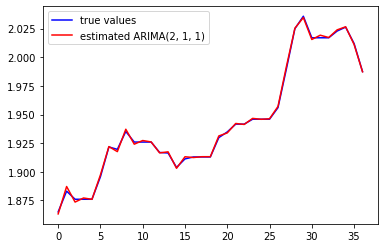

In [31]:
ARIMA_plot_ki(series = Amazon['High'], order = (2,1,1), train_size_percent = 0.9, scale = 1000)

In [32]:
AIC_BIC_HIQC(Amazon['High'])

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

AIC (1, 1)
BIC (1, 0)
HQIC (1, 0)


=====================================================================================================================

### Apple High Price

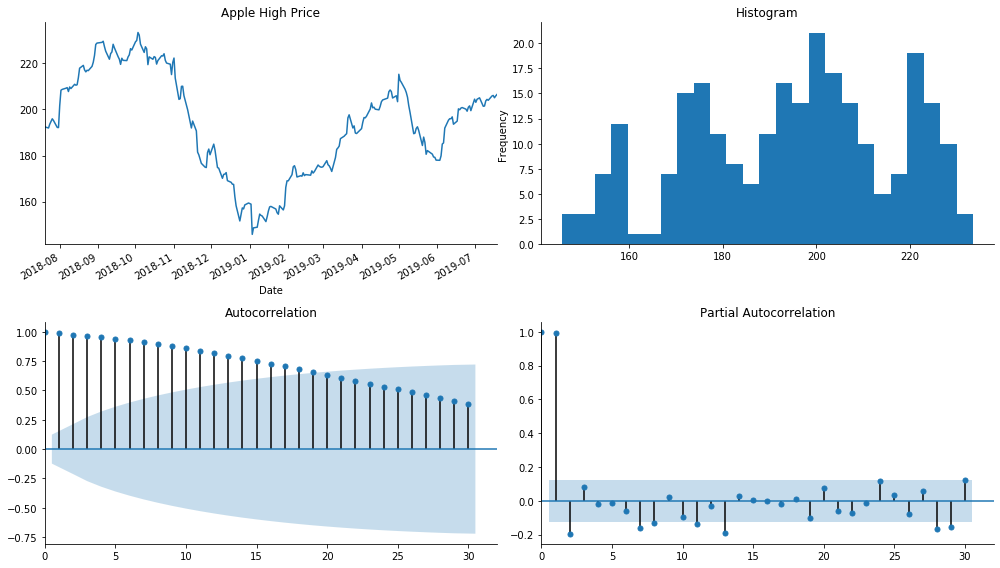

In [33]:
tsplot(AAPL_df['High'], title = 'Apple High Price', lags = 30);

In [34]:
print(fit_ARIMA(AAPL_df['High'], order = (5,2,0)))

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D2.High   No. Observations:                  249
Model:                 ARIMA(5, 2, 0)   Log Likelihood                -645.844
Method:                       css-mle   S.D. of innovations              3.231
Date:                Mon, 11 May 2020   AIC                           1305.689
Time:                        16:42:51   BIC                           1330.311
Sample:                             2   HQIC                          1315.600
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0002      0.059      0.003      0.998      -0.115       0.115
ar.L1.D2.High    -0.7326      0.062    -11.891      0.000      -0.853      -0.612
ar.L2.D2.High    -0.6482      0.073     

Test MSE: 1.640


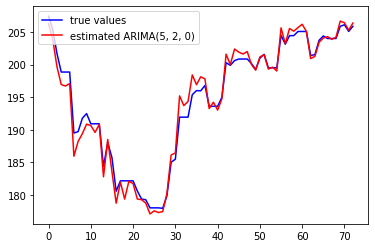

In [35]:
ARIMA_plot_ki(series = AAPL_df['High'], order = (5,2,0), train_size_percent = 0.8)

In [36]:
AIC_BIC_HIQC(AAPL_df['High'])

C:\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: Co

AIC (1, 1)
BIC (1, 0)
HQIC (1, 1)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


========================================================================================================================

### Residual Diagnostic

* The 'residuals' in a time series are what is left over after fitting a model. More precisely, residual is the difference between true and predicted value. 

* For many (but not all) time series models, the **residuals** are equal to the difference between the observations and the corresponding fitted values: 

$$\epsilon_t = X_t - \hat{X_t}$$

* Residuals are useful in checking whether a model has adequately captured the information in the data. 

* A good forecasting model will yield residuals with the following properties: 


1. $\textbf{The residuals are uncorrelated}$. If there are correlations between residuals, then there is information left in the residuals which shoud be used in computing forecasts. This can be done through inspecting acf plot.

2. $\textbf{The residuals have zero mean}$. If the residuals have a mean other than zero, then the forecasts are biased. This can be done in various ways, say, histogram.

3. $\textbf{The residuals follow a normal distribution}.$


C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


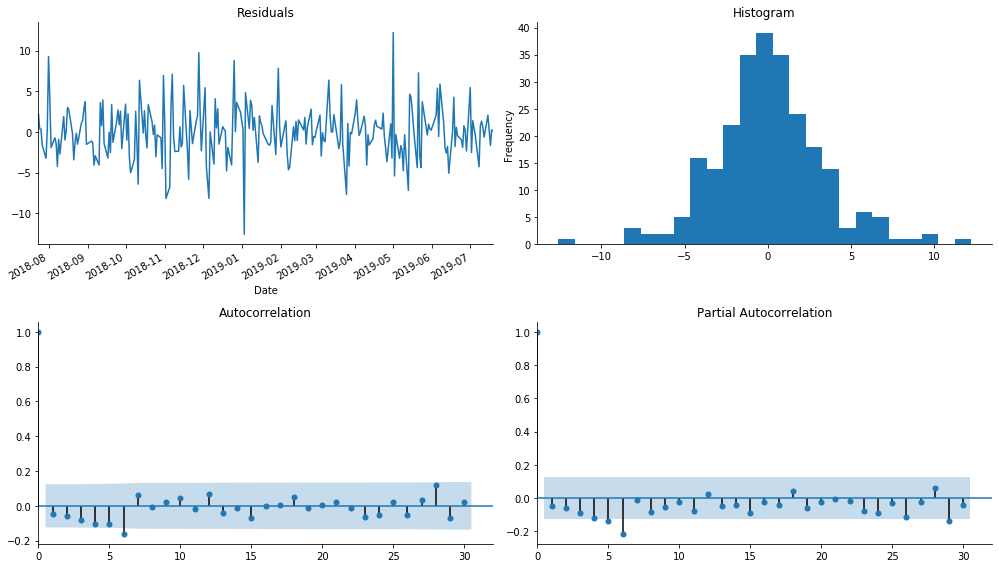

In [39]:
# residual of Apple's stock prices

model = ARIMA(AAPL_df['High'], order = (5,2,0))
model_fit = model.fit(disp=0)
residual = model_fit.resid
tsplot(residual, title = 'Residuals', lags = 30);

* To check normality, one can use Jarque-Bera test.

In [38]:
# determine whether residuals follow a normal distribution
from scipy import stats

jb = stats.jarque_bera(residual)    
print("Jarque-Bera Test Results: ")
print("Test Statistic: %.4f" % jb[0])
print("p-value: %.10f" % jb[1])

Jarque-Bera Test Results: 
Test Statistic: 29.3382
p-value: 0.0000004259


* For Jarque-Bera test, the null hypothesis is that skewness is zero and excess kurtosis is zero, that is, the data follows a normal distribution. Alternative hypothesis would be otherwise.

* Since $p$-value is less than $0.05,$ we should reject null hypothesis. In other words, residuals are not normally distributed.